#**5.7.1 : Time series prediction using LSTM (Tensorflow Keras)**#

Let us look at another implementation of LSTM using Tensorflow Keras. Lets use a dataset called flights data available in seaborn package. You can import the dataset using the command:



```
seaborn.load_dataset
```
We will be using Flights dataset for this example. This dataset records the number of flight passengers that flew in a given route every month from 1949 to 1960. The months are labeled from 0 to 143.


In [1]:
import pandas as pd
import tensorflow as tf
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from google.colab import drive
#drive.mount('/content/gdrive') # This is for Google Collab

csfont = {'fontname':'serif'}
plt.rcParams['font.family'] = "serif"

## **Importing the flights dataset**

The flights dataset consists of the number of airline passengers who flew in each month from 1949 to 1960. This dataset has three variables (year, month, and number of passengers).



In [2]:
data = sns.load_dataset("flights")
print(data.shape)
data.head()


(144, 3)


,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


## Plotting the data

Now let us plot this time series data to visualize the pattern. The plot shows a clear seasonal pattern and growing trend. Seasonality is a property of a time series in which the data goes through predictable and recurring changes on a yearly basis. Now, we are trying to predict this pattern of the data using an LSTM model.

<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:7: SyntaxWarning: invalid escape sequence '\p'
C:\Users\aswathyr\AppData\Local\Temp\ipykernel_15272\4069141479.py:7: SyntaxWarning: invalid escape sequence '\p'
  plt.savefig('Data\plot_flights_Data_orig.pdf')


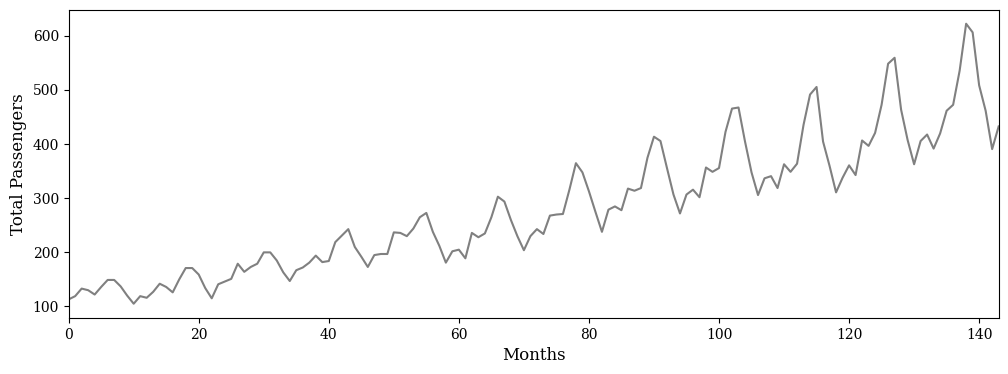

In [3]:

plt.figure(figsize=(12,4))
plt.plot(data['passengers'],color='Grey')
plt.xlabel('Months',fontsize=12,**csfont)
plt.ylabel('Total Passengers',fontsize=12,**csfont)
plt.autoscale(axis='x',tight=True)
#plt.grid(True)
plt.savefig('Data\plot_flights_Data_orig.pdf')
plt.show()

## Data processing step
The passenger data is first split into train and test set in the get_train_test method of the Data_processing class.The training dataset consists of the first 126 samples and the test set is constructed with the remaining samples from month 127 to 144. After this we perform feature normalization using the MinMaxScaler() function. Note that, we fit only the training data to the MinMaxScaler() function and transform both train and test data using the same scaling operation. This is the most efficient way of analyzing the model performance ensuring that the test data is completely new to the model.

We define the XY_split_sequence method to convert the data into a sequence format. Such that a window of samples are passed to the model to prodect the next instant's sample.

In [4]:
class Data_processing(): #Changed from MinMax to StandardScaler

  def __init__(self, data, splitr=30):#, url, n_steps, percent_Split = 0.8):
    #self.url = url
    self.split_range = splitr
    self.data = data

# Parameter split_percent defines the ratio of training examples
  def get_train_test(self):
      n = len(data)
      # Point for splitting data into train and test
      split = int(self.split_range)
      train_data = self.data[:-split]
      test_data = self.data[-split:]
      scaler = StandardScaler()
      self.train_data = scaler.fit_transform(train_data.reshape(-1,1))
      self.test_data = scaler.transform(test_data.reshape(-1,1))
      n = len(data)
      return self.train_data, self.test_data, scaler #, self.data

  def XY_split_sequence(self,seq,ws):
      win = []
      lab = []
      L = len(seq)

      for i in range(L-ws):
        window = seq[i:i+ws,]
        label = seq[i+ws:i+ws+1]
        win.append(window)
        lab.append(label)

      return np.array(win), np.array(lab)

## Plotting train and test data

<>:17: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\p'
C:\Users\aswathyr\AppData\Local\Temp\ipykernel_15272\2165996825.py:17: SyntaxWarning: invalid escape sequence '\p'
  plt.savefig('Data\plot_flights_Data_split.pdf')


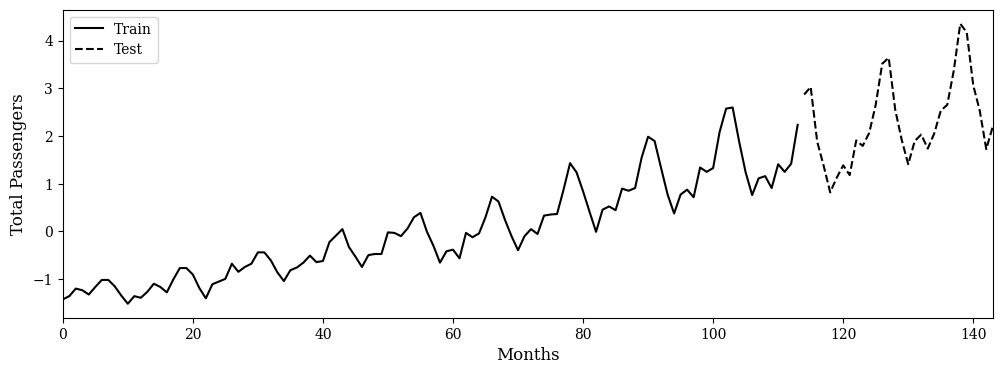

In [5]:
data1=data['passengers'].values.astype(float)
data_module = Data_processing(data1, 30)

plt.figure(figsize=(12,4))
plt.xlabel('Months',fontsize=12,**csfont)
plt.ylabel('Total Passengers',fontsize=12,**csfont)
plt.autoscale(axis='x',tight=True)
X=data_module.get_train_test()
plt.plot(range(X[0].shape[0]),X[0],color='BLACK',label='Train')
r=range(X[0].shape[0],X[0].shape[0]+X[1].shape[0])


plt.plot(r,X[1],color='BLACK',linestyle='--',label='Test')
plt.legend()
#plt.grid(True)

plt.savefig('Data\plot_flights_Data_split.pdf')
plt.show()


## Getting the train-test split for the experiment

In [6]:
train, test, sc = data_module.get_train_test()
window_size=4 #Changed from 12 to 6
trainX, trainY = data_module.XY_split_sequence(train,window_size)
testX, testY = data_module.XY_split_sequence(test,window_size)

In [7]:
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(110, 4, 1) (110, 1, 1) (26, 4, 1) (26, 1, 1)


## Building the LSTM model

We are using Keras here for building the LSTM model. The **Model_setup()** class is defined first and then the **create_LSTMmodel()** method creates the model with the desired specifications that can be passed later on. In this method, we initialize a sequential model with an LSTM layer and a dense layer. We can pass the desired hyperparameters of this model while intializing the class. The hyperparameters that can be passed includes the number of hidden units, that is the dimension of hidden state, number of dense units, shape of the input, activation function that needs to be applied to the layers, the optimizer to be used and the loss function.

The **LSTMmodel_training()** method is used to fit the training data to the model. Here we can pass the training parameters such as number of epochs and batch size alongwith the training data.

In [8]:
class Model_setup():
  def __init__(self, hidden_units, dense_units, input_shape, activation, optimizer, loss):
    self.hidden_units = hidden_units
    self.dense_units = dense_units
    self.input_shape = input_shape
    self.activation = activation
    self.loss = loss
    self.optimizer = optimizer
    self.model = tf.keras.Sequential()

  def create_LSTMmodel(self):

    self.model.add(tf.keras.layers.LSTM(self.hidden_units, input_shape=self.input_shape))#, activation=self.activation[0]))
    self.model.add(tf.keras.layers.Dense(units=self.dense_units))#, activation=self.activation[1]))
    #model.compile(loss='mean_squared_error', optimizer='adam')
    self.model.compile(loss=self.loss, optimizer=self.optimizer)
    return self.model

  def LSTMmodel_training(self, epochs, batch_size, trainX, trainY):
    history = self.model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)
    return self.model, history

Using the above class we can build a sequential model having an LSTM layer followed by a dense layer both with a ***sigmoid*** activation. Here, the loss function is set as ***Mean square error***, and the optimizer is set to ***Adam***. The number of hidden units, that is, the dimension of the hidden state, is set to 100.

In [9]:
model = Model_setup(hidden_units=100, dense_units=1, input_shape=(window_size,1),
                   activation=['sigmoid', 'sigmoid'], optimizer='Adam', loss = 'mean_squared_error')
LSTM_model = model.create_LSTMmodel()
# Changed from 4 to 100 units and tanh, tahn to sigmoid sigmoid

c:\envs\Deepbook\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
LSTM_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

Once the model setup is ready, we can fit the training data to the LSTM model. The training is performed for 500 epochs with a batch size of 16 to obtain the final model.

In [11]:
LSTM_model, history = model.LSTMmodel_training(epochs=500,batch_size=16,trainX = trainX, trainY = trainY) #Changed batch size from 64 to 16

Epoch 1/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0991  
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6394 
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4932 
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3328 
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2512 
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2403 
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2383 
Epoch 8/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1896 
Epoch 9/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2441 
Epoch 10/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2541 
Epoch 11/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2083 
Epoch 12/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1751 
Epoch 13/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2413 
Epoch 14/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1780 
Epoch 15/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1900 
Epoch 16/500
7/7 ━

Now, let us visualize the training loss for the model

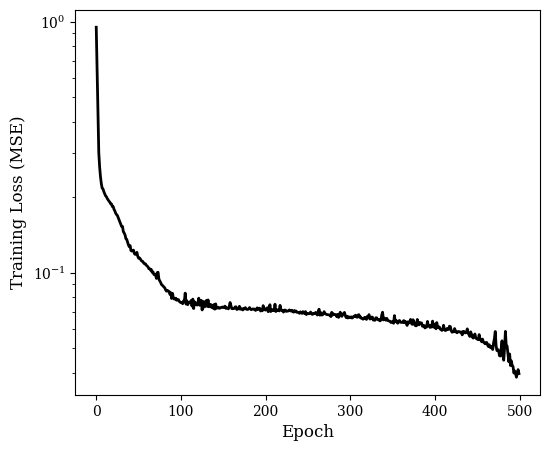

In [12]:
plt.figure(figsize=(6,5))

plt.semilogy(history.history['loss'], lw=2,color='k')
plt.xlabel("Epoch",fontsize=12,**csfont)
plt.ylabel("Training Loss (MSE)",fontsize=12,**csfont)
#plt.savefig('train_loss_lstm.pdf')
plt.show()





We can use the training model to perform prediction on the test data as shown below. For the visualization of the train and test prediction we can perform the on the train data too.

In [13]:
data_predict_train = LSTM_model.predict(trainX)
data_predict = LSTM_model.predict(testX)



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Let us plot the final predictions of the model as shown below. We can see that the model is able to identify the seasonal pattern of the test data. Though the pattern learnt is not exactly same, the performance can be further improved by using multiple lstm layers.

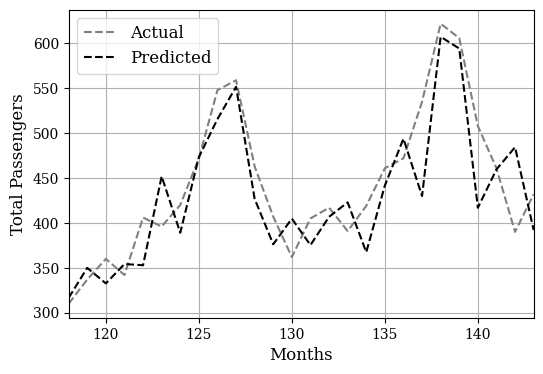

In [14]:
x = np.arange(144-data_predict.shape[0], 144, 1)
data_predict_plot = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(testY.reshape(-1,1))
plt.figure(figsize=(6,4))


plt.plot(x,dataY_plot,color='Grey',label='Actual',linestyle='--')
plt.plot(x,data_predict_plot,color='Black',label='Predicted',linestyle='--')
plt.xlabel('Months',fontsize=12,**csfont)
plt.ylabel('Total Passengers',fontsize=12,**csfont)
plt.autoscale(axis='x',tight=True)
plt.grid()
plt.legend(fontsize=12)
#plt.savefig('predlstm.pdf')
plt.show()

## Visualizing both train and test predictions

(26, 1)
(110, 1)
(110,)


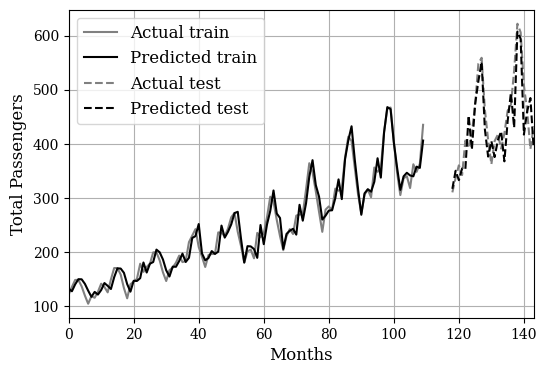

In [15]:


data_predict_plot = sc.inverse_transform(data_predict_train)
dataY_plot = sc.inverse_transform(trainY.reshape(-1,1))
plt.figure(figsize=(6,4))
x = np.arange(0, data_predict_train.shape[0], 1)
print(data_predict.shape)
print(dataY_plot.shape)
print(x.shape)

plt.plot(x,dataY_plot,color='Grey',label='Actual train')
plt.plot(x,data_predict_plot,color='Black',label='Predicted train')
plt.xlabel('Months',fontsize=12,**csfont)
plt.ylabel('Total Passengers',fontsize=12,**csfont)
plt.autoscale(axis='x',tight=True)



data_predict_plot = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(testY.reshape(-1,1))

x = np.arange(144-data_predict.shape[0], 144, 1)
plt.plot(x,dataY_plot,color='Grey',label='Actual test',linestyle='--')
plt.plot(x,data_predict_plot,color='Black',label='Predicted test',linestyle='--')
plt.xlabel('Months',fontsize=12,**csfont)
plt.ylabel('Total Passengers',fontsize=12,**csfont)
plt.autoscale(axis='x',tight=True)
plt.grid()
plt.legend(fontsize=12)

#plt.savefig('predlstm.pdf')
plt.show()

